<a href="https://colab.research.google.com/github/arushig100/Detecting-Malaria-With-CNNs/blob/master/CNNs_to_Detect_Malaria_in_Thin_Blood_Smear_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!chmod 600 /root/.kaggle/kaggle.json
!ls -l ~/.kaggle

#!kaggle datasets list -s malaria

!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!ls
!unzip -q \*.zip



Saving kaggle.json to kaggle (4).json
total 4
-rw------- 1 root root 66 Jul  8 04:40 kaggle.json
cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)
 cell_images				'kaggle (1).json'   kaggle.json
 cell-images				'kaggle (2).json'   sample_data
 cell-images-for-detecting-malaria.zip	'kaggle (3).json'
 drive					'kaggle (4).json'
replace cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
import keras
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Activation, Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D, AveragePooling2D, Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D

Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount('/content/cell-images/')
print(os.listdir('/content/cell_images/'))

Drive already mounted at /content/cell-images/; to attempt to forcibly remount, call drive.mount("/content/cell-images/", force_remount=True).
['Parasitized', 'Uninfected']


## Preprocessing the Data
We are going to begin by **preprocessing the data**. This involves reading in the data, converting it into a different format, and creating the train, validation, and test sets. 

The code below does the following: 

1. Reads in the images from each of the folders (Parasitized and Uninfected)
2. Converts the data (images) to uniform size 64x64 numpy arrays
3. Creates labels (associated with the images) in the form of one hot vectors that represent the diagnosis

All the data is added to one list and all the labels are added to another list. We will soon split these lists into training, validation, and test sets.

In [6]:
parasitized = os.listdir('/content/cell_images/Parasitized/') 
uninfected = os.listdir('/content/cell_images/Uninfected')
data = []
labels = []

for i in parasitized:
    try:
    
        img = cv2.imread('/content/cell_images/Parasitized/'+i)
        img_array = Image.fromarray(img , 'RGB')
        resize_img = img_array.resize((64 , 64))
        data.append(np.array(resize_img))
        label = to_categorical(1, num_classes=2)
        labels.append(label)
        
    except AttributeError:
      pass

print(len(data))

for i in uninfected:
    
    try:
        img = cv2.imread('/content/cell_images/Uninfected/'+i)
        img_array = Image.fromarray(img , 'RGB')
        resize_img = img_array.resize((64 , 64))
        data.append(np.array(resize_img))
        label = to_categorical(0, num_classes=2)
        labels.append(label)
        
    except AttributeError:
      pass
        
print(len(data))


13779
27558


In [9]:
data = np.array(data)
labels = np.array(labels)
print(data.shape , labels.shape)


(27558, 64, 64, 3) (27558, 2)


The following code shuffles the data + labels and normalizes the data.

In [0]:
n = np.arange(data.shape[0])
np.random.shuffle(n)
data = data[n]
labels = labels[n]

data = data.astype(np.float32)
labels = labels.astype(np.int32)
data = data/255

Here, we split the data into **train, validation, and test sets**. The train set will consist of 60% of the data and the validation and test sets will each consist of 20% of the data.

In [11]:

from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)
  
print(x_train.shape, x_val.shape, x_test.shape)



(16534, 64, 64, 3) (5512, 64, 64, 3) (5512, 64, 64, 3)


##Creating the CNN Model
Now, we can begin creating the model. Down below is the code for a 20 layer convolutional neural network (CNN). It uses binary cross entropy for its loss function and Adam as its optimizer.

In [13]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(filters=32, kernel_size=(3,3),strides=(1, 1), input_shape=(64,64,3), activation='relu')) #128
model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
 
model.add(Conv2D(filters=64,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
 
model.add(Conv2D(filters=128,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
 
model.add(Conv2D(filters=128,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
 
model.add(GlobalAveragePooling2D())
 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2,activation='softmax'))
 
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=4, batch_size = 32)



W0708 04:59:09.178877 139639979145088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 04:59:09.195542 139639979145088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 04:59:09.198398 139639979145088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 04:59:09.220443 139639979145088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0708 04:59:09.237920 139639979145088 deprecation_wrapp

Train on 16534 samples, validate on 5512 samples
Epoch 1/4
16534/16534 [==============================] - 20s 1ms/step - loss: 0.2741 - acc: 0.8900 - val_loss: 0.1726 - val_acc: 0.9423
Epoch 2/4
16534/16534 [==============================] - 17s 1ms/step - loss: 0.1639 - acc: 0.9453 - val_loss: 0.1420 - val_acc: 0.9510
Epoch 3/4
16534/16534 [==============================] - 17s 1ms/step - loss: 0.1484 - acc: 0.9503 - val_loss: 0.1400 - val_acc: 0.9505
Epoch 4/4
16534/16534 [==============================] - 17s 1ms/step - loss: 0.1407 - acc: 0.9532 - val_loss: 0.1317 - val_acc: 0.9588


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
__________

The code below evaluates the performance of the model on the test set. The accuracy typically ranges between 95-97% when the model is run multiple times.

In [0]:
print(model.evaluate(x_test, y_test))

5512/5512 [==============================] - 1s 127us/step
[0.12317093646664751, 0.9608127721335269]


##Evaluation Metrics
In order to evaluate how well the model does, we will be plotting a confusion matrix and ROC Curve. 



The **confusion matrix** below shows how many true positives, false positives, true negatives, and false negatives there are.


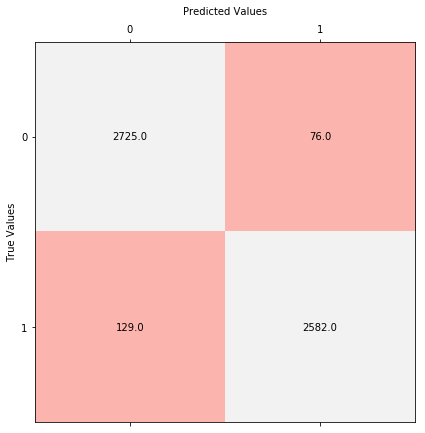

In [15]:
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score

preds = model.predict(x_test)
preds = np.argmax(preds, axis = -1)
orig = np.argmax(y_test, axis=-1)

conf = confusion_matrix(orig, preds)

fig, ax = plt.subplots(figsize = (7,7))
ax.matshow(conf, cmap='Pastel1')

ax.set_ylabel('True Values')
ax.set_xlabel('Predicted Values', labelpad = 10)
ax.xaxis.set_label_position('top') 

for (i, j), z in np.ndenumerate(conf):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

The following displays a **ROC (Reciever Operating Characteristic) Curve** or a plot of the true positive rate against the false positive rate. The AUC (area under the curve) is 0.99. 

(5512, 2) (5512,)


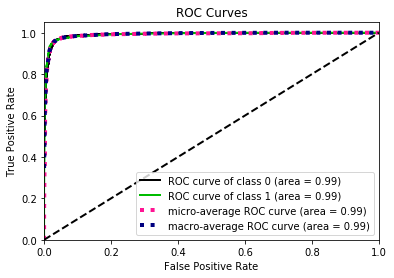

In [16]:
! pip install scikit-plot
import scikitplot
preds = model.predict(x_test)
orig = np.argmax(y_test, axis=-1)
print(preds.shape, orig.shape)
scikitplot.metrics.plot_roc(orig, preds)

plt.show()
